### Importing Library

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


import cudf
pd.set_option('display.max_columns', 500)
import time
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler as scale
from sklearn.decomposition import PCA
from sklearn.cluster import k_means
from sklearn.model_selection import train_test_split as split 
from sklearn.model_selection import GridSearchCV as Grid
import xgboost as xgb
from sklearn.metrics import (roc_auc_score, precision_score, recall_score, f1_score,
                             confusion_matrix, accuracy_score, roc_curve, auc)

/kaggle/input/jane-street-market-prediction/example_sample_submission.csv
/kaggle/input/jane-street-market-prediction/features.csv
/kaggle/input/jane-street-market-prediction/example_test.csv
/kaggle/input/jane-street-market-prediction/train.csv
/kaggle/input/jane-street-market-prediction/janestreet/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jane-street-market-prediction/janestreet/__init__.py


### Loading data

In [2]:
%%time
#train_cudf  = cudf.read_csv('/kaggle/input/jane-street-market-prediction/train.csv')
#train = train_cudf.to_pandas()
#del train_cudf

train  = pd.read_csv('/kaggle/input/jane-street-market-prediction/train.csv')
features_df = pd.read_csv('../input/jane-street-market-prediction/features.csv')
example_test = pd.read_csv('../input/jane-street-market-prediction/example_test.csv')
sample_prediction_df = pd.read_csv('../input/jane-street-market-prediction/example_sample_submission.csv')
print ("Data is loaded!")

Data is loaded!
CPU times: user 1min 23s, sys: 7.31 s, total: 1min 30s
Wall time: 2min 39s


In [3]:
print('train shape is {}'.format(train.shape))
print('features shape is {}'.format(features_df.shape))
print('example_test shape is {}'.format(example_test.shape))
print('sample_prediction_df shape is {}'.format(sample_prediction_df.shape))

train shape is (2390491, 138)
features shape is (130, 30)
example_test shape is (15219, 133)
sample_prediction_df shape is (15219, 2)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float64(135), int64(3)
memory usage: 2.5 GB


### Trying to save some memory

In [8]:
train.feature_0 = train.feature_0.astype(np.int8)
train.date = train.date.astype(np.int16)
train.ts_id = train.ts_id.astype(np.int32)
train = train.astype({c: np.float32 for c in train.select_dtypes(include='float64').columns})

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float32(135), int16(1), int32(1), int8(1)
memory usage: 1.2 GB


The memory usage has benen reduced by more than half.

### Exploratory Data Analysis

AttributeError: module 'matplotlib.pyplot' has no attribute 'xlable'

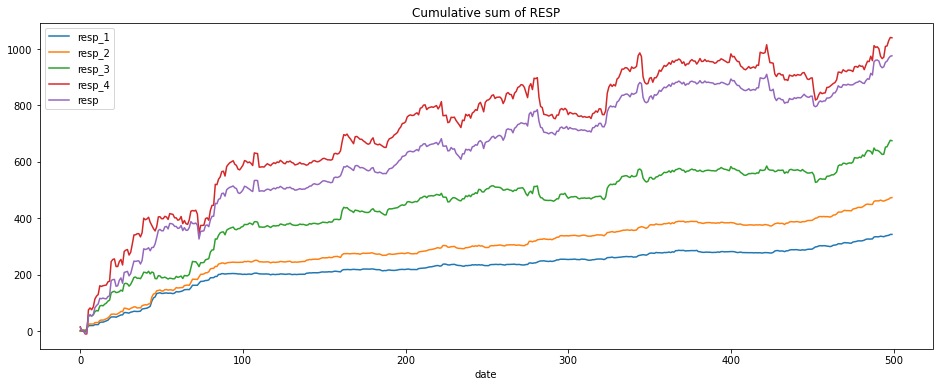

In [14]:
fig = plt.figure(figsize=(16, 6))
ax = plt.subplot(1, 1, 1)
train.groupby('date')[['resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp']].sum().cumsum().plot(ax=ax)
plt.title('Cumulative sum of RESP')
plt.xlabel('Date')
plt.legend(ncol=3, loc=2)

In [13]:
train.groupby('date')[['resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp']].sum()

,resp_1,resp_2,resp_3,resp_4,resp
date,,,,,
0,0.110208,0.201025,2.572470,15.392179,12.764341
1,3.642896,3.057404,-1.134088,-15.254713,-11.235455
2,0.179333,0.179333,0.178037,0.175167,0.176875
3,-1.368786,-2.286007,-3.160054,-10.127345,-10.132756
4,5.519654,7.201784,5.732317,-0.117414,3.442627
...,...,...,...,...,...
495,2.599576,2.215436,24.937935,38.429638,15.793063
496,1.398151,2.628190,1.391299,1.357738,4.089449
497,1.049636,2.235030,12.166384,18.522717,10.288340


In [ ]:
train = train[train['weight'] > 0]
train['action'] = (train['resp'].values > 0).astype('int')

train.fillna(train.mean(),inplace=True)

features = [c for c in train.columns if 'feature' in c]
features_mean = train[features].mean().values
X_train = train[features].values
y_train = train['action'].values

del train, features_df, example_test, sample_prediction_df

In [ ]:
import xgboost as xgb
print("XGBoost version:", xgb.__version__)

clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=11,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.7,
    missing=-999,
    random_state=2020,
    tree_method='gpu_hist'  # THE MAGICAL PARAMETER
)

%time clf.fit(X_train, y_train)

In [ ]:
TRAINING = True

start_time = time.time()

if TRAINING:
    import janestreet
    env = janestreet.make_env()
    th = 0.5
    for (test_df, pred_df) in tqdm(env.iter_test()):
        if test_df['weight'].item() > 0:
            x_tt = test_df.loc[:, features].values
            if np.isnan(x_tt.sum()):
                x_tt = np.nan_to_num(x_tt) + np.isnan(x_tt) * features_mean    ## why add np.isnan?
            pred = clf.predict(x_tt)
            pred_df.action = np.where(pred >= th, 1, 0).astype(int)
        else:
            pred_df.action = 0
        env.predict(pred_df)
        
print(f"took: {time.time() - start_time} seconds")

In [ ]:
env.predictions    